In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [8]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5022,00026599_000.png,No Finding,0,26599,039Y,F,PA,2021,2021,0.194311,0.194311
3441,00016972_024.png,Effusion|Infiltration,24,16972,043Y,F,AP,2500,2048,0.168000,0.168000
332,00001788_007.png,No Finding,7,1788,047Y,M,AP,2500,2048,0.168000,0.168000


## EDA

In [9]:
# First look into our df
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [10]:
# Checking df shape
all_xray_df.shape

(112120, 12)

Our dataframe has 112120 rows and 12 columns

In [11]:
# Checking column names
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [12]:
# Checking patient sex distribution
all_xray_df["Patient Gender"].value_counts()

M    63340
F    48780
Name: Patient Gender, dtype: int64

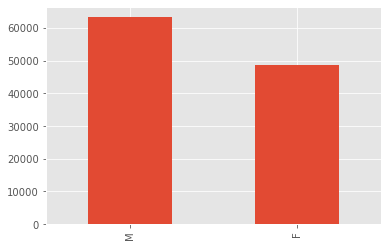

In [13]:
# Plotting gender distribution
plt.style.use('ggplot')
all_xray_df["Patient Gender"].value_counts().plot(kind="bar")

In [14]:
# Checking image position distribution
all_xray_df["View Position"].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

PA= Posterior - Anterior
AP= Anterior - Posterior
Determines from whcih side the X-rays entered.

In [15]:
# checking numerical variable basic statistics
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


We can notice how there is an erroneus value in patient age, where the age is 414 years old. We will look further into that case.

In [16]:
all_xray_df[all_xray_df["Patient Age"]==414]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN


We  will replace the value with 41.

In [17]:
all_xray_df["Patient Age"] = all_xray_df["Patient Age"].replace([414],41)

In [18]:
# Checking the differential disease value counts
dd= all_xray_df["Finding Labels"].value_counts()

As we can see, there are 836 unique entries. No finding is the most common finding (pun intended). Moreover, a lot of unique values are combinations of various disease findings.

In [19]:
sort= dd.sort_values(ascending=False)
    

In [20]:
sort.head(30)

No Finding                           60361
Infiltration                          9547
Atelectasis                           4215
Effusion                              3955
Nodule                                2705
Pneumothorax                          2194
Mass                                  2139
Effusion|Infiltration                 1603
Atelectasis|Infiltration              1350
Consolidation                         1310
Atelectasis|Effusion                  1165
Pleural_Thickening                    1126
Cardiomegaly                          1093
Emphysema                              892
Infiltration|Nodule                    829
Atelectasis|Effusion|Infiltration      737
Fibrosis                               727
Edema                                  628
Cardiomegaly|Effusion                  484
Consolidation|Infiltration             441
Infiltration|Mass                      420
Effusion|Pneumothorax                  403
Effusion|Mass                          402
Atelectasis

Pneumonia is the only 30th most common value. 

<Figure size 1800x1080 with 0 Axes>

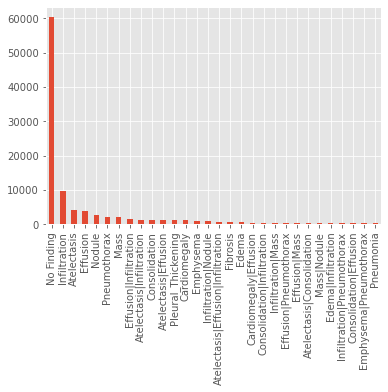

In [21]:
# Plotting 30 most common radiologic findings
plt.figure(figsize=(25, 15))
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=10)
sort.head(30).plot(kind="bar")

Therefore we have only 322 "pure" pneumonia findings. Next, we will check how many pneumonia findings are in co-occurence with other diseases.

In [22]:
# Exctracting all rows which contain a substring "Pneumonia"
result = all_xray_df["Finding Labels"].str.contains(pat = 'Pneumonia')

In [23]:
pneum_comb= all_xray_df[result]
pneum_comb

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,0.139,NaN
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,0.139,NaN
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,0.139,NaN
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,0.139,NaN


We have 1431 rows that have solo pneumonia or a combination of pneumonia and some other comorbidity.

In [24]:
pneum_comb["Finding Labels"].value_counts()

Pneumonia                                                                                         322
Infiltration|Pneumonia                                                                            199
Edema|Infiltration|Pneumonia                                                                      137
Atelectasis|Pneumonia                                                                             108
Edema|Pneumonia                                                                                    83
                                                                                                 ... 
Emphysema|Infiltration|Pleural_Thickening|Pneumonia                                                 1
Effusion|Mass|Pneumonia|Pneumothorax                                                                1
Effusion|Pneumothorax|Pneumonia                                                                     1
Atelectasis|Consolidation|Nodule|Pneumonia                                        

Five most common findings are Pneumonia, Infiltration|Pneumonia , Edema|Infiltration|Pneumonia, Atelectasis|Pneumonia, Edema|Pneumonia.

To find disease combination count, we will implement a function that detects special chars (in this case we have | as a character that seperates our target values). Hence the num of | +1 equals our target count.

In [25]:
#Python program to count the number of 
#Special Characters in a string.
def count_special_character(string): 
  
    # Declaring variable for special characters 
    special_char= 0
   
    for i in range(0, len(string)):  
    # len(string) function to count the 
    # number of characters in given string.
      
        ch = string[i]
  
        #.isalpha() function checks whether character 
        #is alphabet or not.
        if (string[i].isalpha()):  
            continue
        
        #.isdigit() function checks whether character 
        #is a number or not.
        elif (string[i].isdigit()):
            continue
            
        else: 
            special_char += 1
            
            
    return special_char

In [26]:
all_xray_df["Disease_count"]= all_xray_df.apply(lambda all_xray_df: count_special_character(all_xray_df["Finding Labels"]), axis=1)



In [27]:
# Checking result
all_xray_df.head(50)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Disease_count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,NaN,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,NaN,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,NaN,1
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171000,0.171000,NaN,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000,NaN,0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,0.168000,NaN,0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168000,0.168000,NaN,0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143000,0.143000,NaN,1
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168000,0.168000,NaN,0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143000,0.143000,NaN,0


In [28]:
# Exctracting all rows which contain a substring "Pneumonia"
result = all_xray_df["Finding Labels"].str.contains(pat = 'Pneumonia')

In [29]:
# Creating new pneumonia dataframe that has the new "Disease count" column
pneum_comb= all_xray_df[result]
pneum_comb

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Disease_count
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,2
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,3
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,1
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,5
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,0.139,NaN,2
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,0.139,NaN,2
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,0.139,NaN,0
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,0.139,NaN,1


In [30]:
# Adding plus 1 to "Disease count", since we just counted the number of "|" in the string
pneum_comb["Disease_count"] += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
pneum_comb

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Disease_count
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,3
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,4
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,2
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,6
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,0.139,NaN,3
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,0.139,NaN,3
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,0.139,NaN,1
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,0.139,NaN,2


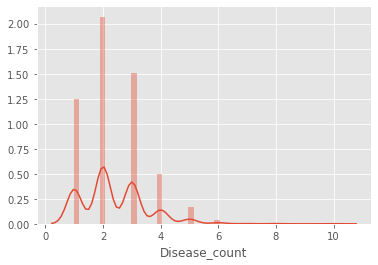

In [32]:
# Ploting a histogram of "Disease_count"
sns.distplot(pneum_comb["Disease_count"])

We can see that the most common finding is 2 commorbidities.

In [33]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [34]:
#sample_df will be used for this EDA
from itertools import chain
s_labels=np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
s_labels=[x for x in s_labels if len(x)>0]
print(s_labels)

for label in s_labels:
    if len(label)>1:
        sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
sample_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Find image paths for png listed.  Code from Model section
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.head()

Scans found: 0 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,None
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,None
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None


In [36]:
import pydicom
from pydicom import dcmread
my_dicom = pydicom.dcmread("test1.dcm")

In [37]:
my_dicom

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

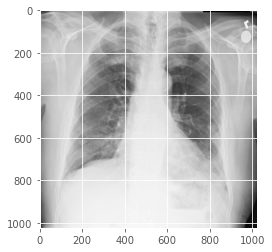

In [39]:
# Checking out the first test image
plt.imshow(my_dicom.pixel_array,cmap='gray')

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

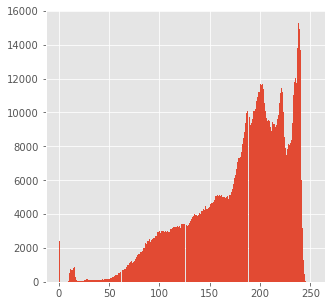

In [40]:
plt.figure(figsize=(5,5))
plt.hist(my_dicom.pixel_array.ravel(), bins = 256)

In [41]:
dcm2= pydicom.dcmread("test2.dcm")

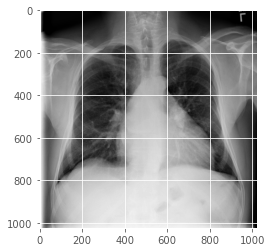

In [42]:
plt.imshow(dcm2.pixel_array,cmap='gray')

(array([13386.,  2532.,  3043.,  4455.,  7220.,  7741.,  1954.,  1499.,
         1278.,  1154.,  1208.,  1226.,  1329.,  1421.,  1385.,  1449.,
         1521.,  1662.,  1678.,  1892.,  2060.,  2038.,  2205.,  2404.,
         2561.,  2628.,  2800.,  2834.,  3012.,  3106.,  3086.,  3300.,
         3427.,  3422.,  3636.,  3759.,  3973.,  3954.,  4013.,  4040.,
         4284.,  4169.,  4200.,  4232.,  4474.,  4588.,  4616.,  4695.,
         4691.,  4671.,  4842.,  4959.,  4900.,  5059.,  5207.,  5314.,
         5165.,  5089.,  5027.,  5015.,  5077.,  4751.,  4851.,  4585.,
         4714.,  4449.,  4438.,  4351.,  4327.,  4348.,  4285.,  4302.,
         4170.,  4235.,  4150.,  4249.,  4405.,  4410.,  4567.,  4570.,
         4531.,  4431.,  4186.,  3957.,  3985.,  3871.,  3711.,  3778.,
         3607.,  3584.,  3420.,  3416.,  3370.,  3459.,  3426.,  3422.,
         3441.,  3493.,  3457.,  3277.,  3184.,  3147.,  3180.,  3165.,
         3112.,  3213.,  3232.,  3260.,  3445.,  3550.,  3683., 

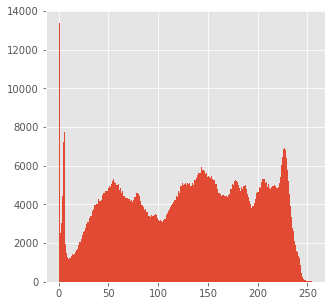

In [43]:
plt.figure(figsize=(5,5))
plt.hist(dcm2.pixel_array.ravel(), bins = 256)

We can see that the first image has white pathces throught the lungs, which is indicative of pneumonia or edema. On the other hand, the second image has clear "black" lungs, therefore it is a normal finding. Moreover, the two pictures have completely different pixel intensity distributions (which we can see on the two histograms above).

In [44]:
# Exctracting all rows which contain a substring "Pneumonia"- this time for the sample df
res_2 = sample_df["Finding Labels"].str.contains(pat = 'Pneumonia')

In [45]:
sample_pneum= sample_df[res_2]

In [46]:
sample_pneum

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
256,00001373_010.png,Cardiomegaly|Effusion|Pneumonia,10,1373,058Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,None
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,None
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,None
723,00003789_000.png,Nodule|Pneumonia,0,3789,041Y,M,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,None
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,047Y,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5168,00027589_001.png,Effusion|Pneumonia,1,27589,014Y,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,None
5189,00027725_073.png,Emphysema|Pneumonia|Pneumothorax,73,27725,021Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,None
5201,00027757_002.png,Effusion|Infiltration|Pneumonia,2,27757,021Y,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,None
5366,00028924_005.png,Pneumonia,5,28924,072Y,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,None


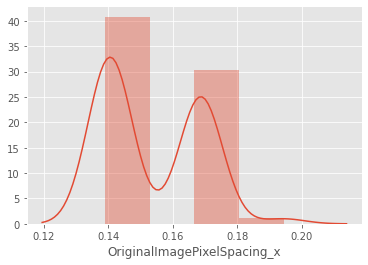

In [47]:
sns.distplot(sample_pneum["OriginalImagePixelSpacing_x"])

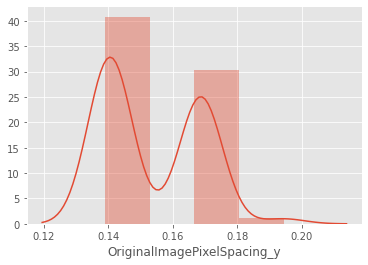

In [48]:
sns.distplot(sample_pneum["OriginalImagePixelSpacing_y"])